In [4]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time
import onnxruntime_ep_iree as iree_ep

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Set verbose logging
onnxruntime.set_default_logger_severity(0)

%matplotlib inline

In [5]:
# prepare progressbar
def show_progress(block_num, block_size, total_size):
    print("Downloaded: " + str(round(block_num * block_size / total_size *100,2)) + "%", end="\r")

import urllib.request

onnx_model_url = "https://huggingface.co/onnxmodelzoo/resnet50_Opset18_torch_hub/resolve/main/resnet50_Opset18_torch_hub.onnx"
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# retrieve our model from the ONNX model zoo
urllib.request.urlretrieve(onnx_model_url, filename="model.onnx", reporthook=show_progress)
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json", reporthook=show_progress)

Downloaded: 115.31%

('imagenet-simple-labels.json', <http.client.HTTPMessage at 0x79f9e69000e0>)

In [6]:
import pathlib

# Register the EP plugin
onnxruntime.register_execution_provider_library(iree_ep.get_ep_name(), iree_ep.get_library_path())
print("EP plugin registered successfully")

EP plugin registered successfully


2026-02-09 14:05:35.384684736 [I:onnxruntime:Default, utils.cc:552 LoadPluginOrProviderBridge] Loading EP library: /home/kunwar/Work/iree-onnx-ep/build/libonnxruntime_ep_iree.so as a plugin
2026-02-09 14:05:35.712970885 [I:onnxruntime:Default, iree_ep_factory.cc:201 GetDeviceForId] IREE EP: Created HAL device for device_id 0 (hip://GPU-33336561-6162-6338-3539-323735616466)
2026-02-09 14:05:35.712999178 [I:onnxruntime:Default, iree_ep_factory.cc:466 CreateAllocatorImpl] IREE EP: Created allocator for device 0
2026-02-09 14:05:35.713015292 [I:onnxruntime:Default, iree_ep_factory.cc:201 GetDeviceForId] IREE EP: Created HAL device for device_id 1 (local-sync://)
2026-02-09 14:05:35.713017656 [I:onnxruntime:Default, iree_ep_factory.cc:466 CreateAllocatorImpl] IREE EP: Created allocator for device 1
2026-02-09 14:05:35.747593365 [I:onnxruntime:Default, iree_ep_factory.cc:201 GetDeviceForId] IREE EP: Created HAL device for device_id 2 (local-task://)
2026-02-09 14:05:35.747605594 [I:onnxrunti

In [7]:
# Get IREE device
ep_devices = onnxruntime.get_ep_devices()
iree_device = None
for dev in ep_devices:
    print(dev.device.metadata)

{}
{'iree.device_id': '0', 'iree.device_path': 'GPU-33336561-6162-6338-3539-323735616466', 'iree.driver': 'hip'}
{'iree.device_id': '1', 'iree.device_path': '', 'iree.driver': 'local-sync'}
{'iree.device_id': '2', 'iree.device_path': '', 'iree.driver': 'local-task'}
{'iree.device_id': '3', 'iree.device_path': '00000000-e300-0000-0000-000000000000', 'iree.driver': 'vulkan'}


In [8]:
# For hip execution (rdna4)
driver = "hip"
arch = "gfx1201"
# For cpu execution
# driver = "local-task"
# arch = "none"

In [9]:
# Get IREE device
ep_devices = onnxruntime.get_ep_devices()
iree_device = None
for dev in ep_devices:
    if dev.device.metadata.get('iree.driver') == driver:
        iree_device = dev
        break

if not iree_device:
    print("ERROR: IREE EP not found in EP devices")

print(f"IREE EP available (vendor={iree_device.ep_vendor})")
print(f"Chosen Device: {iree_device.device.metadata}")

IREE EP available (vendor=IREE)
Chosen Device: {'iree.device_id': '0', 'iree.device_path': 'GPU-33336561-6162-6338-3539-323735616466', 'iree.driver': 'hip'}


In [10]:
sess_options = onnxruntime.SessionOptions()
provider_options = {
    "target_arch": arch,
    "opt_level": "O3",
}
sess_options.add_provider_for_devices([iree_device], provider_options)

# Run the model on the backend
session = onnxruntime.InferenceSession('model.onnx', sess_options=sess_options)

2026-02-09 14:05:41.810098490 [I:onnxruntime:, inference_session.cc:606 TraceSessionOptions] Session Options {  execution_mode:0 execution_order:DEFAULT enable_profiling:0 optimized_model_filepath:"" enable_mem_pattern:1 enable_mem_reuse:1 enable_cpu_mem_arena:1 profile_file_prefix:onnxruntime_profile_ session_logid: session_log_severity_level:-1 session_log_verbosity_level:0 max_num_graph_transformation_steps:10 graph_optimization_level:4 intra_op_param:OrtThreadPoolParams { thread_pool_size: 0 auto_set_affinity: 0 allow_spinning: 1 dynamic_block_base_: 0 stack_size: 0 affinity_str:  set_denormal_as_zero: 0 } inter_op_param:OrtThreadPoolParams { thread_pool_size: 0 auto_set_affinity: 0 allow_spinning: 1 dynamic_block_base_: 0 stack_size: 0 affinity_str:  set_denormal_as_zero: 0 } use_per_session_threads:1 thread_pool_allow_spinning:1 use_deterministic_compute:0 ep_selection_policy:0 config_options: {   ep.iree.target_arch: gfx1201  ep.iree.opt_level: O3 } }
2026-02-09 14:05:41.8101135

In [12]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
        
    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def prepare_image(image):
    return preprocess(np.array(image).transpose(2, 0, 1))

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

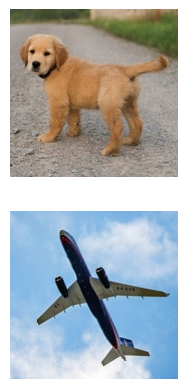

In [13]:
labels = load_labels('imagenet-simple-labels.json')
image0 = Image.open('images/dog.jpg')
image1 = Image.open('images/plane.jpg')

_, axarr = plt.subplots(2, 1)
axarr[0].axis("off")
axarr[0].imshow(image0)
axarr[1].axis("off")
axarr[1].imshow(image1)

input0 = prepare_image(image0)
input1 = prepare_image(image1)

In [14]:
def run_inference(inp, image):
    start = time.time()
    raw_result = session.run([], {"x": inp})
    end = time.time()
    res = postprocess(raw_result)

    inference_time = np.round((end - start) * 1000, 2)
    
    print('========================================')
    print('Inference time: ' + str(inference_time) + " ms")
    print('========================================')

    idx = np.argmax(res)

    print('========================================')
    print('Final top prediction is: ' + labels[idx])
    print('========================================')

    sort_idx = np.flip(np.squeeze(np.argsort(res)))
    print('============ Top 5 labels are: ============================')
    print(labels[sort_idx[:5]])
    print('===========================================================')
    
    plt.axis('off')
    display_image = plt.imshow(image)

Inference time: 19.73 ms
Final top prediction is: Golden Retriever
============ Top 5 labels are: ============================
['Golden Retriever' 'Labrador Retriever' 'Flat-Coated Retriever'
 'Curly-coated Retriever' 'Norwich Terrier']


2026-02-09 14:05:55.096653387 [I:onnxruntime:Default, iree_allocator.cc:89 AllocImpl] IREE EP: Allocated 602112 bytes on device 0 (buffer=0x268adde0)
2026-02-09 14:05:55.096677373 [I:onnxruntime:Default, iree_data_transfer.cc:113 CopyTensorsImpl] IREE EP: Data transfer 1/1: H2D, 150528 elements, 602112 bytes, src_device=0, dst_device=0
2026-02-09 14:05:55.097481135 [I:onnxruntime:, iree_ort_utils.cc:149 OrtTensorToIreeBufferView] IREE EP: Input tensor already on device, wrapping existing buffer (602112 bytes)
2026-02-09 14:05:55.115378494 [I:onnxruntime:Default, iree_allocator.cc:89 AllocImpl] IREE EP: Allocated 4000 bytes on device 0 (buffer=0x26791640)
2026-02-09 14:05:55.115393357 [I:onnxruntime:, iree_ort_utils.cc:207 IreeBufferViewToOrtTensor] IREE EP: Output tensor on device, performing D2D copy (4000 bytes)
2026-02-09 14:05:55.115484895 [I:onnxruntime:Default, bfc_arena.cc:333 AllocateRawInternal] Extending BFCArena for Cpu. bin_num:4 (requested) num_bytes: 4000 (actual) rounded

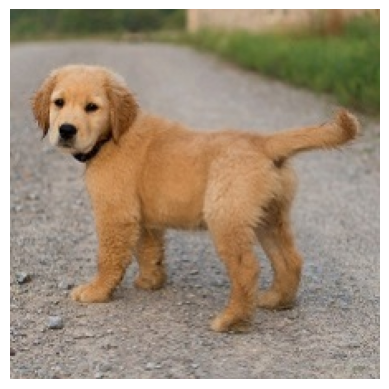

In [15]:
run_inference(input0, image0)

Inference time: 19.66 ms
Final top prediction is: airliner
============ Top 5 labels are: ============================
['airliner' 'military aircraft' 'wing' 'space shuttle' 'airship']


2026-02-09 14:05:55.794874095 [I:onnxruntime:Default, iree_allocator.cc:89 AllocImpl] IREE EP: Allocated 602112 bytes on device 0 (buffer=0x26a9d1b0)
2026-02-09 14:05:55.794895317 [I:onnxruntime:Default, iree_data_transfer.cc:113 CopyTensorsImpl] IREE EP: Data transfer 1/1: H2D, 150528 elements, 602112 bytes, src_device=0, dst_device=0
2026-02-09 14:05:55.795947714 [I:onnxruntime:, iree_ort_utils.cc:149 OrtTensorToIreeBufferView] IREE EP: Input tensor already on device, wrapping existing buffer (602112 bytes)
2026-02-09 14:05:55.814029221 [I:onnxruntime:Default, iree_allocator.cc:89 AllocImpl] IREE EP: Allocated 4000 bytes on device 0 (buffer=0x26e3e810)
2026-02-09 14:05:55.814039206 [I:onnxruntime:, iree_ort_utils.cc:207 IreeBufferViewToOrtTensor] IREE EP: Output tensor on device, performing D2D copy (4000 bytes)
2026-02-09 14:05:55.814177624 [I:onnxruntime:Default, iree_data_transfer.cc:113 CopyTensorsImpl] IREE EP: Data transfer 1/1: D2H, 1000 elements, 4000 bytes, src_device=0, dst

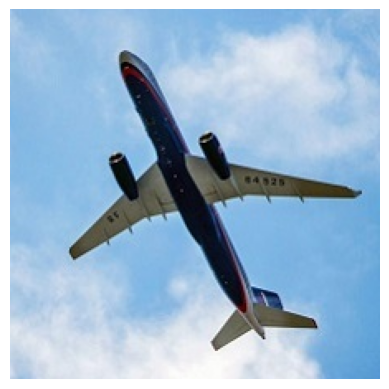

In [16]:
run_inference(input1, image1)